# Identifying Tactical Graphics via Machine Learning Classification - Part 1
## By: Matthew Jacobsen, updated: 5/4/2020

In one of my other [articles](), I went through the process needed to video screen record a user terminal for use the both quantitative and qualitative assessment of systems. Near the end of that tutorial, I demonstrated how to take the information on a map based screen image and convert it to tabular data for statistical analysis.  

One aspect that we did not cover in that project was how to enhance the information devliered for evaluation.  In particular, the data obtained from the previous process included time stamps for new graphics appearing and the real world coordinates.  However, we could not inform the evaluator of the *type* of graphic being observed.  In this walkthrough, we will cover how to isolate and extract additional graphics from frames as they appear.  In addition, we will go over the use of machine learning techniques to identify and textualize what graphic the computer believes was observed.  

### Why?

For those unfamiliar with the process of system evaluation or testing, this may seem like a significant amount of work for only a modest gain in information. In some sense, this is true. However, the goal of operational testing is to ensure a quality system is delivered to the end user and that it is reliable in the information it delivers.  In order to achieve such an assessment, we need to be able to evaluate, as in the previous article, position accuracy and delivery timeliness, but also the accuracy of the information itself. 

In order to get a concept of how large a problem space this is, take a look at the [quantity of graphics that can be displayed to a Soldier](www.spatialillusions.com/unitgenerator).  This mind-bogglingly large quantity of graphics, along with the fact that evaluators seldom have reason to understand all of them, can quickly convince you that this problem is either (1) too difficult or (2) not worth the effort. However, there are a multitude of walkthroughs on the internet showing how to construct a classifier for distinguishing dogs and cats, so the idea is reasonable.  

This is exactly the reason that we turn to machine learning methods for image classification.  This problem is beyond the scope of any individual evaluator and, as would be expected, the Mark 1 eyeball is not an appropriate tool for this task (yay, military evaluator humor). We just need to make it work for a *substantially larger set* of graphics and we would want an automated pathway, so we can reduce the burden on the analyst/evaluator.

The immediate benefit is that, if we can build such a classifier, we can automate the process so the evaluator gets results that indicate how accurate the graphical position was to the data that was received or sent, how timely that data was (how long it took to get to the out port of the computer), *and* how accurate the graphic was to what was intended. Given these are the three critical elements of any information on a command and control system, this is enough to say whether said system meets its intended purpose from a functional standpoint. Anything beyond that is how useful the system is to the actual user, which is a separate evaluation construct altogether.

### The Process

While we could follow walkthroughs that already exist for similar problems, this problem is unique enough, that it merits going through the process required.  So, here are our steps:

- First, we need to obtain *as complete as possible* a set of military graphics for use. 

- Next, we need to create a set of graphics overlaid on various maps. The reason for this is that we want our machine learning algorithm to focus on the graphic and features of it, as opposed to the background.  So, we can help out a bit by providing as broad and random as possible a set of backgrounds, to discourage such a focus. This process should generate both a training/test set and a validation set, so we have some measure of how our algorithm will perform in the real world.

- Finally, we will need to train and test the algorithm, as well as package it for use outside of our development environment.

We also have some requirements of the process.  For example, the huge quantity of graphics available will necessitate an automated process. This is not just to save us some work now, but also for the future, as these graphics are updated on a fairly routine basis (exactly why is a question better left for others than me). 

With all that said, let's dive in.  This part of the full walkthrough will focus on the first two parts of our process. We will cover how to automatically obtain the graphics and how to merge them with backgrounds in an automatic fashion to obtain our graphical data. There are other methods we can use later to extend our graphics base set, so that our algorithm can be less dependent on orientation, but for now we'll stick to simpler methods of accomplishing this.

### Obtaining the Graphics

As linked earlier, the nice folks at Spatial Illusions have created a web-based Javascript application to build a wide range of military graphics. Figure 1 below shows a screen capture of this website. Since we are looking for an automatic method of generating the graphics, we can make use of this website to simplify our process and push the collection of graphics to Python. 

<img src='spatialillusions.png'>
<b><center>Figure 1 : Spatial Illusion's Unit Generator</center></b>

In order to do this, you will need the Selenium package, which allows Python (and other code bases) to interact with websites in an automatic fashion.  Figure 1 also includes several dropdown menus boxed in red.  These are the main elements that we will be iterating through the collect our graphics.  

First, let's import the packages we need, which also includes the BeautifulSoup package for extracting and parsing web elements.  We'll also define our website name, to save time later.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.support.ui import Select, WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup
import time
import pickle
import re
import os

url1 = 'https://spatialillusions.com/unitgenerator/'

Next, let's create a set of functions to help out later.  The first will instantiate our webdriver for Selenium and the second will collect the current options in any of the dropdown menus.  This will be important as those options will update as the code cycles through.

In [2]:
def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--incognito')

    browser = webdriver.Chrome(r'C:\Users\Matt\Documents\Personal File\Python Code Packages\selenium_drivers\chromedriver.exe', options=options)
    
    return browser

def update_options(handle, driver):
    html = driver.page_source
    soup = BeautifulSoup(html)
    
    updated_options = [
        [
            x for x in b.find_all('li')
        ] for b in soup.find_all('div',{'class':handle})
    ]
    updated_options = [x.text for x in updated_options[0]]

    return updated_options

We'll also need to consider how to store our graphics.  The graphics generated by this website are encoded as base64 text strings, so we are using a data dictionary that will have a numerical key (incremented by the graphic number).  Inside this will be three sub-elements, the text description of the graphic, the symbol code (which is a character string representing that graphic), and the base64 test itself, which we can convert to a graphic later.

Just in case there is a problem, we don't want to start over from square one, so we'll have the code check to see if there are already stored graphics to use, and make sure it starts from that point.  If not, then it will start from the beginning.  NOTE: Make sure that this code is in the executable portion of your final package, otherwise you'll end up starting from scratch after the first attempt. 

In [18]:
collected_graphics = {}

for file in os.listdir():
    if file == 'collected_graphics.pkl':
        with open('collected_graphics.pkl','rb') as infile:
            collected_graphics = pickle.load(infile)
            
            starting_elements = collected_graphics[list(collected_graphics.keys())[len(collected_graphics.keys())-1]]['symbol_text'].split('|')
            
            cs_start = starting_elements[0]
            aff_start = starting_elements[1]
            bd_start = starting_elements[2]
            stat_start = starting_elements[3]
            fid_start = starting_elements[4]
            
            counter = list(collected_graphics.keys())[len(collected_graphics.keys())-1]
            
            aff_flag = True
            bd_flag = True
            stat_flag = True
            fid_flag = True

if collected_graphics == {}:
    cs_start = None
    aff_start = None
    bd_start = None
    stat_start = None
    fid_start = None
    counter = 0   

    aff_flag = False
    bd_flag = False
    stat_flag = False
    fid_flag = False

Finally, let's limit the graphics we look at a bit, to streamline the process. To demonstrate that the graphics are **are not capturing** won't matter very much, you can take a look and compare the differences. Although you could try to interact with all elements by class name or some other variable, **lots** of experimentatation was done to find the combination that worked the best.  By using absolute xpaths, we leave ourselves vulnerable if the website structure changes, but this is likely to be relatively easy to fix. 

After defining our elements, we start by selecting values from each of the dropdowns and interating through them. The scheme through which we have done this puts the two smallest lists at the bottom.  This is especially important, as interacting with the Function ID menu was found to be finnicky, so going through that just one time proved to be the best. 

In [ ]:
driver = web_driver()
driver.get(url1)
driver.implicitly_wait(30)

affiliation_list = ['Pending','Unknown','Assumed Friend','Friend','Neutral','Suspect','Hostile']
status_list = ['Anticipated/Planned','Present']


cs_text_xpath = '/html/body/section/div/div[1]/div[3]/div/div[2]/ul/li[{}]'
aff_text_xpath = '/html/body/section/div/div[1]/div[4]/div/div[2]/ul/li[{}]'
bd_text_xpath = '/html/body/section/div/div[1]/div[5]/div/div[2]/ul/li[{}]'
stat_text_xpath = '/html/body/section/div/div[1]/div[6]/div/div[2]/ul/li[{}]'
fid_text_xpath = '/html/body/section/div/div[1]/div[7]/div/div[2]/ul/li[{}]'

cs_curopt_xpath = "/html/body/section/div/div[1]/div[3]/div/div[1]/*[@class='mdc-select__selected-text']"
aff_curopt_xpath = "/html/body/section/div/div[1]/div[4]/div/div[1]/*[@class='mdc-select__selected-text']"
bd_curopt_xpath = "/html/body/section/div/div[1]/div[5]/div/div[1]/*[@class='mdc-select__selected-text']"
stat_curopt_xpath = "/html/body/section/div/div[1]/div[6]/div/div[1]/*[@class='mdc-select__selected-text']"
fid_curopt_xpath = "/html/body/section/div/div[1]/div[7]/div/div[1]/*[@class='mdc-select__selected-text']"

cs_menu = driver.find_element_by_class_name("coding-scheme")
aff_menu = driver.find_element_by_class_name("affiliation")
bd_menu = driver.find_element_by_class_name("battle-dimension")
stat_menu = driver.find_element_by_class_name("status")
fid_menu = driver.find_element_by_class_name("function-id")

cs_curopt = driver.find_element_by_xpath(cs_curopt_xpath)
aff_curopt = driver.find_element_by_xpath(aff_curopt_xpath)
bd_curopt = driver.find_element_by_xpath(bd_curopt_xpath)
stat_curopt = driver.find_element_by_xpath(stat_curopt_xpath)
fid_curopt = driver.find_element_by_xpath(fid_curopt_xpath)

cs_options = update_options("coding-scheme", driver)

if cs_start != None:
    cs_index = cs_options.index(cs_start)
else:
    cs_index = 0
    
while cs_index <= len(cs_options)-1:
    cs_ext = cs_options[cs_index]
    
    print(cs_ext)
    cs_actions = ActionChains(driver)
        
    cs_selector = driver.find_element_by_xpath(cs_text_xpath.format(cs_index+1))
    cs_actions.move_to_element(cs_menu).pause(2).perform()
    cs_actions.click().pause(2).perform()
    cs_actions = ActionChains(driver)

    cs_actions.move_to_element(cs_selector).pause(2).perform()
    cs_actions.click().pause(2).perform()
    
    bd_options = update_options("battle-dimension", driver)
    
    if (bd_start != None) and (bd_flag):
        bd_index = bd_options.index(bd_start)
        bd_flag = False

    else:
        bd_index = 0   

    while bd_index <= len(bd_options)-1:
        bd_ext = bd_options[bd_index]

        print('-'+bd_ext)
        bd_actions = ActionChains(driver)

        bd_selector = driver.find_element_by_xpath(bd_text_xpath.format(bd_index+1))
        bd_actions.move_to_element(bd_menu).pause(2).perform()
        bd_actions.click().pause(2).perform()
        bd_actions = ActionChains(driver)

        bd_actions.move_to_element(bd_selector).pause(2).perform()
        bd_actions.click().pause(2).perform()
        
        fid_options = update_options("function-id", driver)
        fid_options = [re.sub(r'[^0-9A-Za-z-_ ]+',' ',x) for x in fid_options]
        if (fid_start != None) and (fid_flag):
            fid_index = fid_options.index(fid_start)
            fid_flag = False
        else:
            fid_index = 0
        
        while fid_index <= len(fid_options)-1:
            fid_ext = fid_options[fid_index]

            print('--'+fid_ext)
            
            while re.sub(r'[^0-9A-Za-z-_ ]+',' ',fid_curopt.text).strip() != re.sub(r'[^0-9A-Za-z-_ ]+',' ',fid_ext).strip():
                fid_actions = ActionChains(driver)

                fid_selector = driver.find_element_by_xpath(fid_text_xpath.format(fid_index+1))
                fid_actions.move_to_element(fid_menu).pause(2).perform()
                fid_actions.click().pause(2).perform()
                fid_actions = ActionChains(driver)

                fid_actions.move_to_element(fid_selector).pause(2).perform()
                fid_actions.click().pause(2).perform()
            
            stat_options = update_options("status", driver)
            
            if (stat_start != None) and (stat_flag):
                stat_index = stat_options.index(stat_start)
                stat_flag = False

            else:
                stat_index = 0
                stat_actions = ActionChains(driver)
                stat_selector = driver.find_element_by_xpath(stat_text_xpath.format(stat_index+1))
                stat_actions.move_to_element(stat_menu).pause(2).perform()
                stat_actions.click().pause(2).perform()
                stat_actions = ActionChains(driver)

                stat_actions.move_to_element(stat_selector).pause(2).perform()
                stat_actions.click().pause(2).perform()
                                    
            while stat_index <= len(status_list)-1:
                stat_ext = status_list[stat_index]

                print('---'+stat_ext)
                while stat_curopt.text != stat_ext:
                    stat_actions = ActionChains(driver)

                    stat_actions.move_to_element(stat_menu).pause(2).perform()
                    stat_actions.click().pause(2).perform()
                    stat_actions = ActionChains(driver)
                    stat_actions.send_keys(Keys.DOWN).pause(2).perform()
                    stat_actions = ActionChains(driver)
                    stat_actions.send_keys(Keys.ENTER).pause(2).perform()
                
                aff_options = update_options("affiliation", driver)
    
                if (aff_start != None) and (aff_flag) and (stat_flag) :
                    aff_index = aff_options.index(aff_start)
                    aff_flag = False

                else:
                    aff_index = 0
                    aff_actions = ActionChains(driver)
                    aff_selector = driver.find_element_by_xpath(aff_text_xpath.format(aff_index+1))
                    aff_actions.move_to_element(aff_menu).pause(2).perform()
                    aff_actions.click().pause(2).perform()
                    aff_actions = ActionChains(driver)

                    aff_actions.move_to_element(aff_selector).pause(2).perform()
                    aff_actions.click().pause(2).perform()
                
                while aff_index <= len(affiliation_list)-1:
                    aff_ext = affiliation_list[aff_index]

                    print('----'+aff_ext)
                    while aff_curopt.text != aff_ext:
                        aff_actions = ActionChains(driver)

                        aff_actions.move_to_element(aff_menu).pause(2).perform()
                        aff_actions.click().pause(2).perform()
                        aff_actions = ActionChains(driver)
                        aff_actions.send_keys(Keys.DOWN).pause(2).perform()
                        aff_actions = ActionChains(driver)
                        aff_actions.send_keys(Keys.ENTER).pause(2).perform()
                    
                    symbol_information = driver.find_element_by_class_name("svg-symbol")
                    image_information = driver.find_element_by_xpath('/html/body/section/div/div[1]/div[1]/center/div/img')
                    
                    collected_graphics[counter] = {}
                    collected_graphics[counter]['symbol_text'] = cs_ext+'|'+aff_ext+'|'+bd_ext+'|'+stat_ext+'|'+fid_ext
                    collected_graphics[counter]['symbol_code'] = symbol_information.get_attribute('sidc')
                    collected_graphics[counter]['base64_img_src'] = image_information.get_attribute('src')
                    
                    aff_index += 1
                    counter += 1   
                
                stat_index += 1
            
            fid_index += 1
        
        bd_index += 1
    
    cs_index += 1

driver.close()

with open('collected_graphics.pkl','wb') as outfile:
    pickle.dump(collected_graphics, outfile, protocol=2)

This part **will** take a while.  During my initial collection of these graphics, it took over a week of constant running to aggregate a set of graphics that I was happy with, so be prepared to spend some time on this.  

### Converting Graphics 

Now that we have our graphics, we will have to convert them into actual images from the base64 text they are generated as.  Lucky for us, this is a fairly simple process.  In order to convert them, we will use the python imaging library (PIL), the base64 library, and the io library.  The process is shown below. In order to demonstrate this, we have an example base64 string image below and are using the matplotlib library to show the graphic inline. 

In this example, we take the base64 text and decode it, then use the IO library to pipe that output into PIL's image stream.  

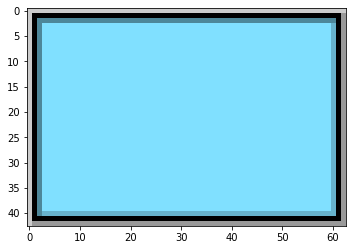

In [5]:
from matplotlib.pyplot import imshow
import numpy as np

%matplotlib inline

import base64
from PIL import Image
from io import BytesIO

image = "iVBORw0KGgoAAAANSUhEUgAAAD8AAAArCAYAAADPGFBSAAAAsElEQVRoQ+3aYQ2AIBCG4aOGGfyHNQhgAclgAjOQwxr4yxDWcDDHhprg7rXBd5zfoxtORLwYfdwTPhvMH1v4sCUz+fc1lqx9eD8v6gdwnYekMBG+W3tOXvnis/a887R9/cLLxXkKj8LTOwHanran7Wl7qMN5vcrVZFAHdVAHdVAHdVCndwI4j/M4j/M4j/N6leOXFudxHudxvjo/jDau5H0uJCkX7i9eu4pm48hfI7gBP64eKp8Ai0YAAAAASUVORK5CYII="

im = Image.open(BytesIO(base64.b64decode(image)))

imshow(np.asarray(im))

Although the goal is to make a image classifier for all of the graphics we can, to simplify the process and enable others to use what is developed here, I've limited the remainder of this walkthrough to focus on a generic version of the seven affiliations we looked at in the graphic collection portion.  Figure 2 shows these, with the affiliation names listed over the graphic itself (those are not part of our machine learning algorithm).

<img src='graphics.png'>
<b><center> Figure 2: Generic Unit Graphics </center></b>

The reason for this limitation is both to make this walkthrough more easy to apply on a broad set of computing platforms and also because extending the process to all graphics is not a significant enhancement of what we are doing.

### Creating a Standardized Data Set

Now that we have our base military graphics, we can generate the graphics that will be used for data set creation.  First, we need backgrounds that are satellite map based, as that is our expected background for assessment graphics. By picking a diverse enough set of backgrounds, the actual background for the graphics we process in a real use case should matter less than the graphics.  So, to encourage this, we have a set of 13 satellite images obtained from Google Maps.  Figure 3 shows one example of these images. 

<img src='big_bg1.png'>
<b><center>Figure 3: Example Satellite Imagery Background</center></b>

We could go through and create individual images from a single satellite image, but that is a little .... time consuming for this type of project.  Additionally, we can find similar looking images all over the planet.  What we really want is to have a reasonable representation of the different potential backgrounds that might appear.  So, let's get creative.  

We are going to use a standardized image size of 40x40 pixels, just for simplicity. Each of these images is about 1200x500 pixels, so we can get around 330 distinct images out of each image, so with 13 total images we have over 4000 backgrounds to use.  To do this, we continue using the PIL package and raster across the image, cropping and saving a 40x40 pixel window and incrementing the file name. 

In [ ]:
# Import Packages
from PIL import Image
from PIL import ImageMath
import PIL
import numpy as np
import math
import os

# Specify Backgrounds
bg_list = [
    'big_bg1.png',
    'big_bg2.png',
    'big_bg3.png',
    'big_bg4.png',
    'big_bg5.png',
    'big_bg6.png',
    'big_bg7.png',
    'big_bg8.png',
    'big_bg9.png',
    'big_bg10.png',
    'big_bg11.png',
    'big_bg12.png',
    'big_bg13.png'
]

# Define Output Directory
os.chdir(r'C:\Users\Matt\Documents\Personal File\Python Code Packages\Tool Assisted Analysis Suite\GraphicIdentificationMachineLearning\Backgrounds')

# Loop through background list
for bg in bg_list:
    
    # Load the background
    big_bg = Image.open(bg,'r')
    
    # Get the name from the file name
    name = bg[:bg.find('.')]
    
    # Obtain the width and height of the image in pixels
    w, h = big_bg.size
    
    # Calculate the maximum number of images that can be obtained from the parent image
    num_cols = round(w/40)
    num_rows = round(h/40)
    
    # Iterate through saving out each 40x40 pixel square.
    row = 0
    while row < num_rows:
        col = 0
        while col < num_cols:
            left = col * 40
            top = row * 40        
            im1 = big_bg.crop((left, top, left+40, top+40))
            im1.save(name+'_'+str(col)+'_'+str(row)+'.png','PNG')
            col+=1
        row+=1

Just to demonstrate that this does what was described above, Figure 4 below shows the 5th frame of the 27th row of Figure 3 (Resized by a factor of 5, to make it easier to see). 

<img src='big_bg1_27_5.png' width=200 height=200>
<b><center>Figure 4: Extracted Background from Figure 3</center></b>

The last step to get us ready to move into preparations for the machine learning model is to merge the graphics from earlier with the backgrounds.  We will do this twice, once for our training/test set and once for the validation set.  So, we'll have Python obtain the names for all the background files, as well as provide Python with the names for the graphic files and a header that will become our label for the model later.  Then, we open both image files, rescale the graphic to half of the overall background size and paste it in.  The key here is to use the graphic to self mask, as this will ensure that the transparent background doesn't show up over our desired background. The code for the validation set is the same as the training/test set, so we'll just show the later of these for now. 

In [3]:
from PIL import Image
from PIL import ImageMath
import PIL
import numpy as np
import math
import os

bg_dir = r'C:\Users\Matt\Documents\Personal File\Python Code Packages\Tool Assisted Analysis Suite\GraphicIdentificationMachineLearning\Backgrounds'
os.chdir(bg_dir)
backgrounds = [x for x in os.listdir() if '.png' in x]

graphic_dir = r'C:\Users\Matt\Documents\Personal File\Python Code Packages\Tool Assisted Analysis Suite\GraphicIdentificationMachineLearning\Overlay Graphics'
os.chdir(graphic_dir)
graphics_to_overlay = [
    ['SAGPU-------.png','Anticipated'],
    ['SFGPU-------.png','Friendly'],
    ['SHGPU-------.png','Hostile'],
    ['SNGPU-------.png','Neutral'],
    ['SPGPU-------.png','Pending'],
    ['SSGPU-------.png','Suspect'],
    ['SUGPU-------.png','Unknown']
]

test_set_dir = r'C:\Users\Matt\Documents\Personal File\Python Code Packages\Tool Assisted Analysis Suite\GraphicIdentificationMachineLearning\testset'
for image in graphics_to_overlay:
    img_name = image[0]
    label = image[1]
    
    img = Image.open(graphic_dir+'\\'+img_name, 'r')
       
    background_counter = 0
    
    for background_name in backgrounds:
        back = Image.open(bg_dir+'\\'+background_name, 'r')
        back = back.convert("RGBA")
        backwidth, backheight = back.size

        new_img_size = (math.ceil(backwidth/2), math.ceil(backheight/2))
        img_new = img.copy()
        img_new.thumbnail(new_img_size, Image.ANTIALIAS)
        width, height = img_new.size
        
        txt_img = Image.new('RGBA', (backwidth, backheight), (0,0,0,0))
        txt_img.paste(back, (0,0))
        txt_img.paste(img_new, (math.ceil((backwidth - width)/2), math.ceil((backheight-height)/2)), mask = img_new)
        txt_img.save(test_set_dir+'\\'+label+'_'+str(background_counter)+'.png','PNG')
        background_counter+=1
    
    

And voila! We have a total of 32,963 png image files, with military graphics overlaid, to use for our test/training set. Just to give some idea what these look like, here's an example:

<img src='Friendly_3772.png' width=200 height=200>
<b><center>Figure 6: Example Training Graphic</center></b>

Using a separate set of backgrounds, we also have a distinct set of 105 graphics to use for validation, which will remain separate from the training/test set. In the next part, we'll work our way through getting this all ready for a neural network algorithm to help with classification.  See you then!